<a href="https://colab.research.google.com/github/SahilTuladhar/TensorFlow-and-Pytorch--Practice/blob/master/01_PyTorch_Workflow_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow Fundamentals
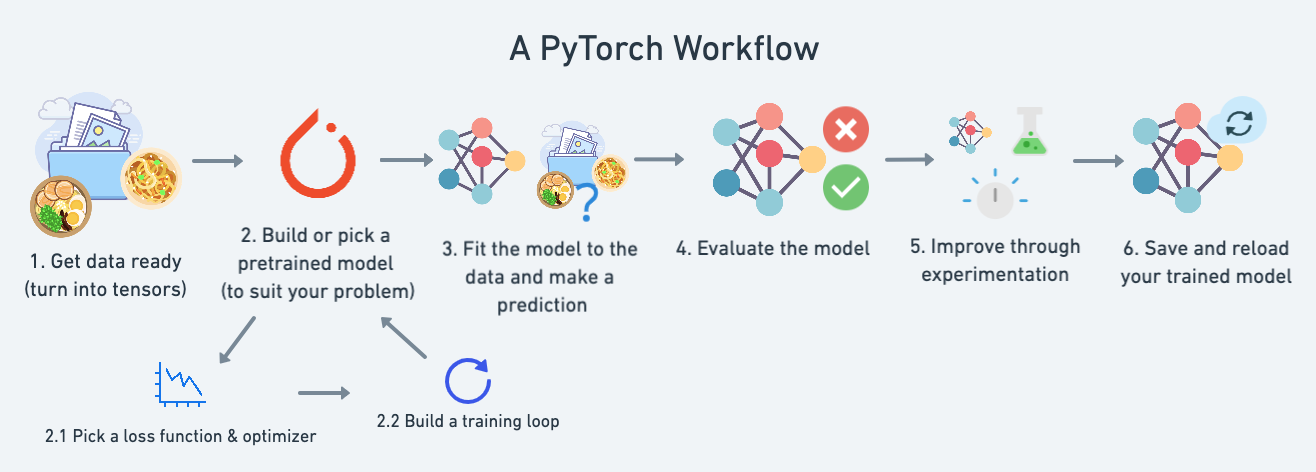

In [22]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [23]:
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [24]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.5.1+cu121'

##1. Data Preparation
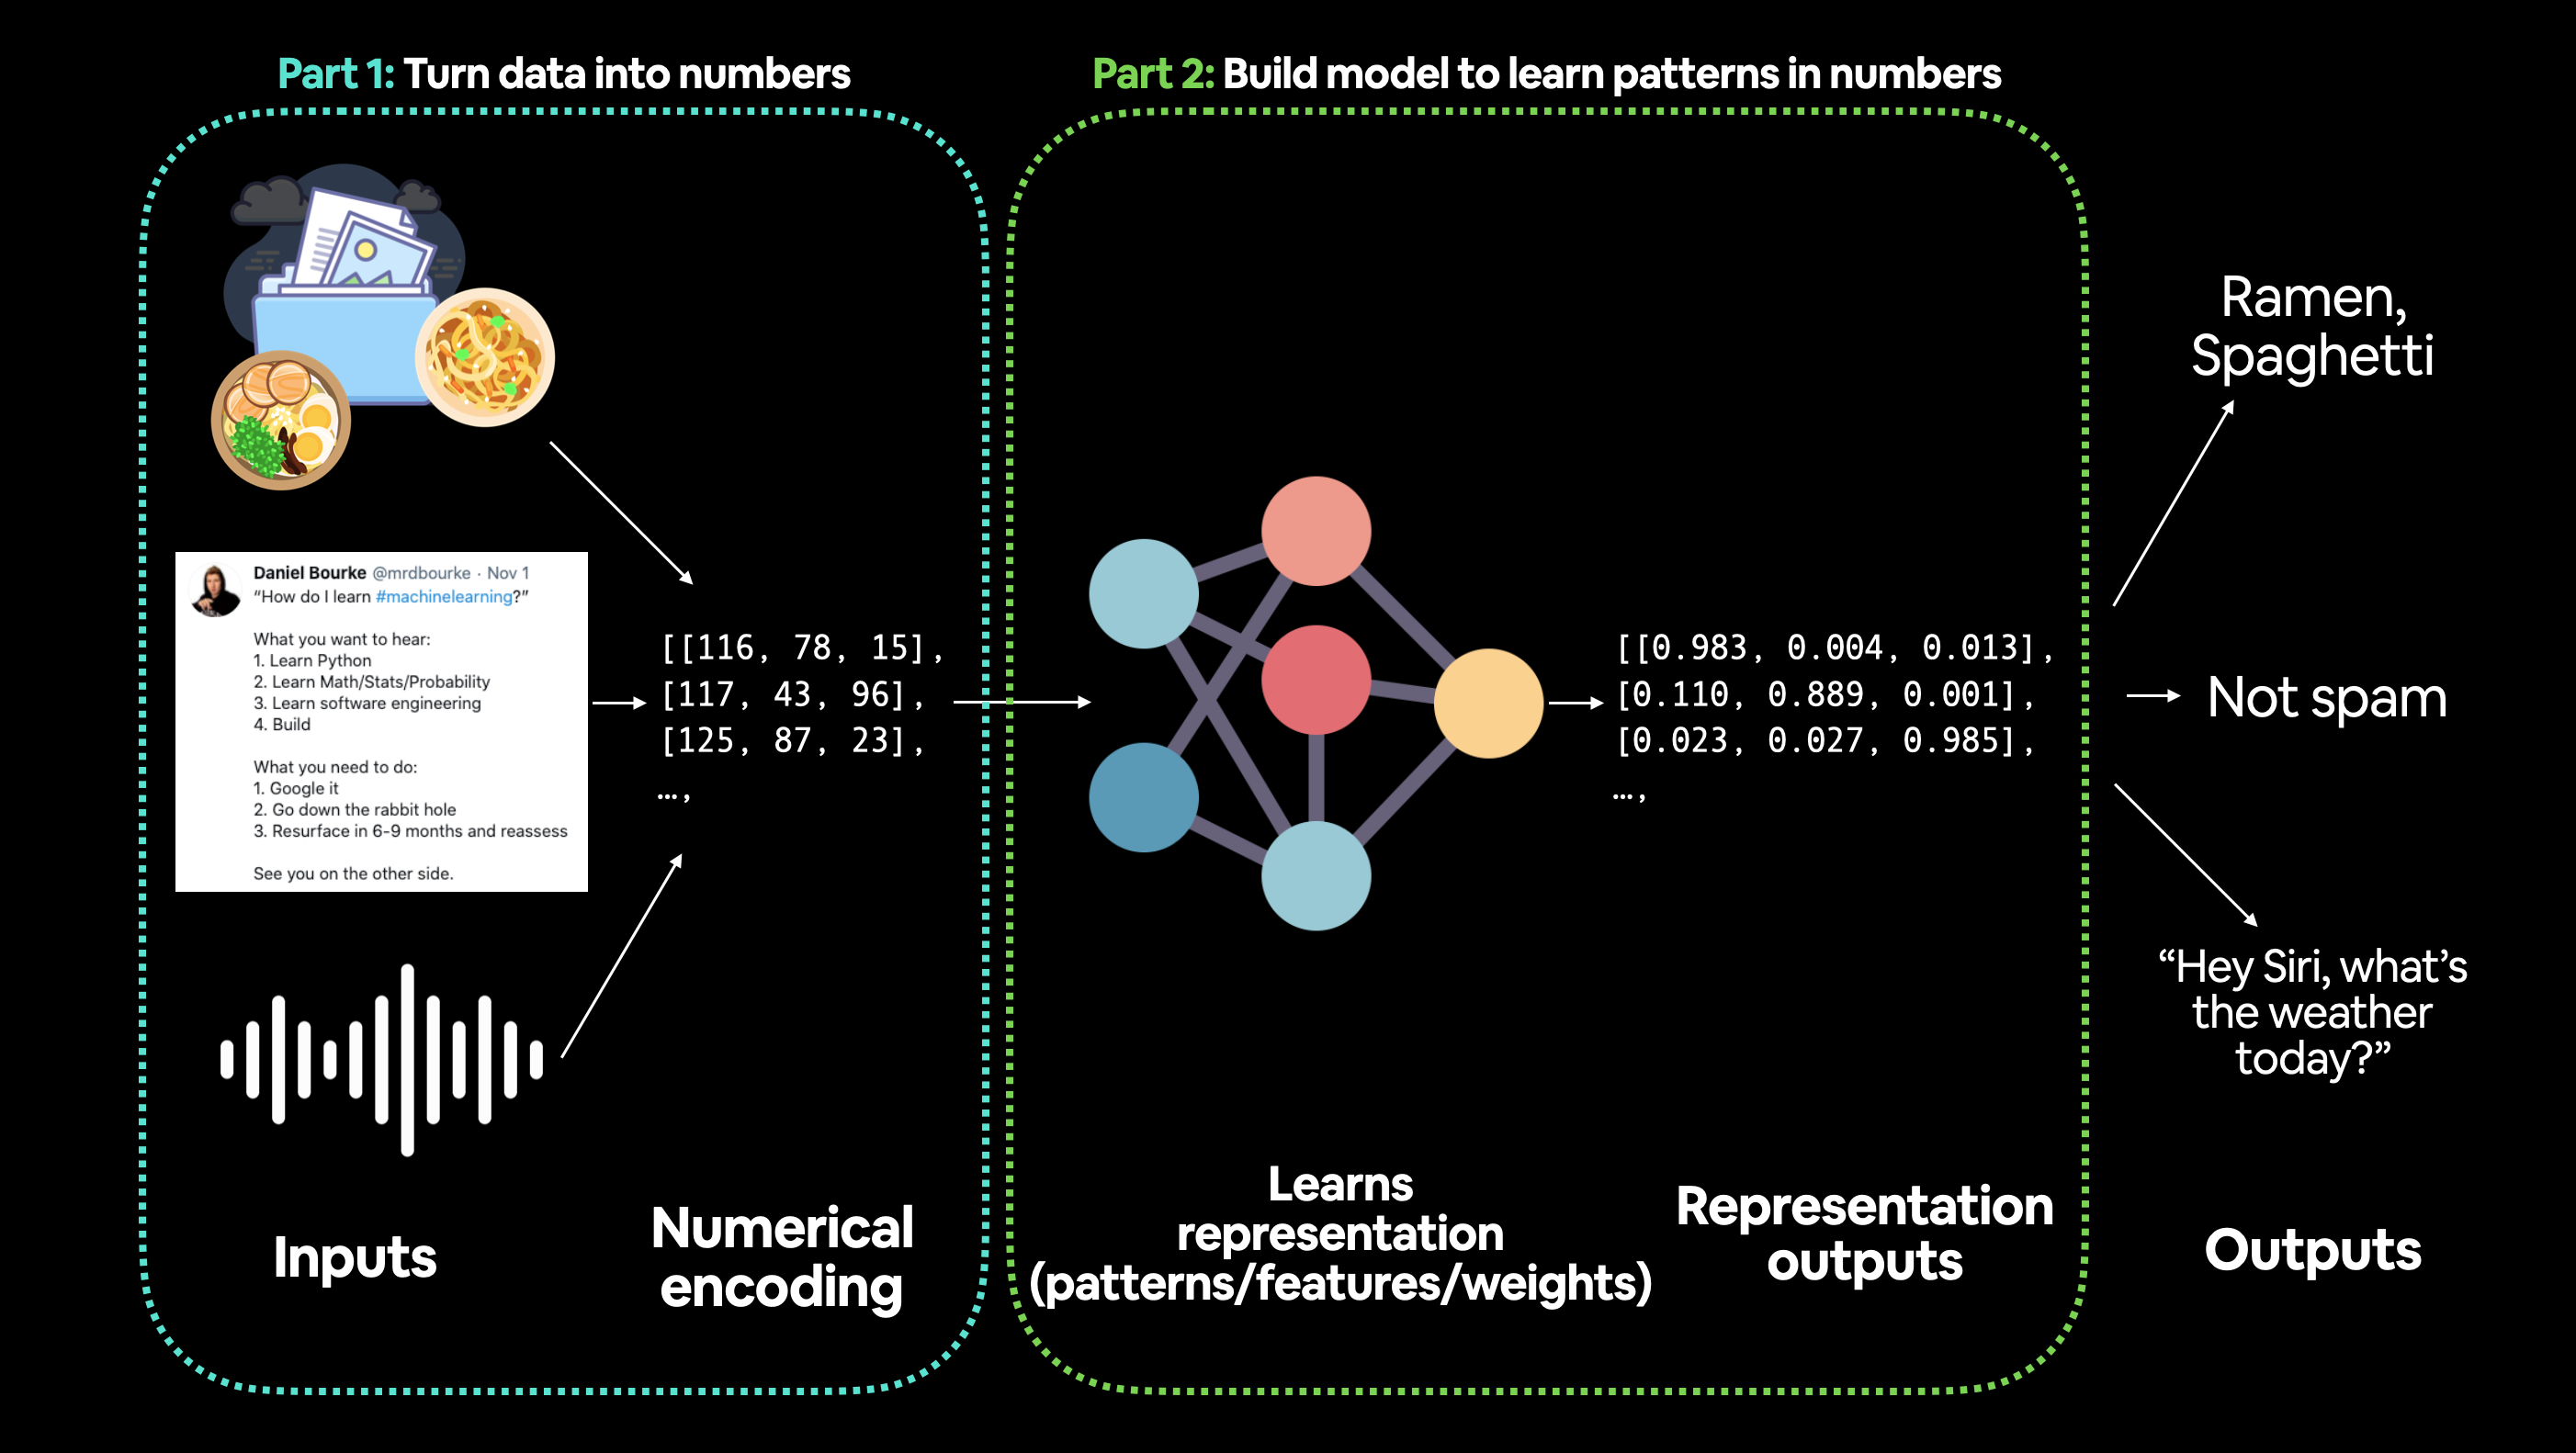

### Creating Data
- creating data using *linear regression formula*
- we will create a straight line with known parameters

In [25]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start , end , step).unsqueeze(dim = 1 )
y = weight * X + bias

X[:10] , y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into traning , and testing set
One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

 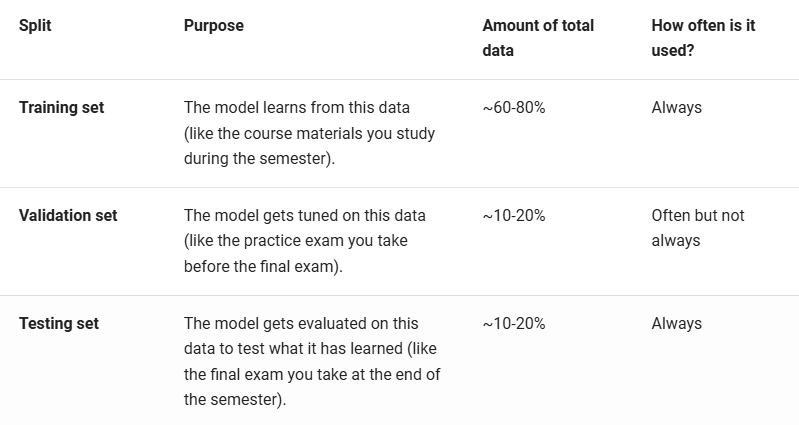

In [26]:
train_split = int(0.8 * len(X)) # 80% data used for training
X_train , y_train = X[:train_split] , y[:train_split]
X_test , y_test = X[train_split:] , y[train_split:]

len(X_train) , len(y_train) , len(X_test) , len(y_test)

(40, 40, 10, 10)

In [27]:
def plot_predictions(train_data = X_train,train_label = y_train , test_data = X_test, test_label = y_test , predictions = None):

   plt.figure(figsize = (10,7))

   plt.scatter (train_data , train_label , c ='b' , s=4 , label ="Training data")

   plt.scatter(test_data , test_label , c = 'g' , s=4 , label = "Testing data")

   if predictions is not None:
    plt.scatter(test_data , predictions , c='r' , s = 4 , label = "Predictions")

   plt.legend(prop = {'size' : 15});

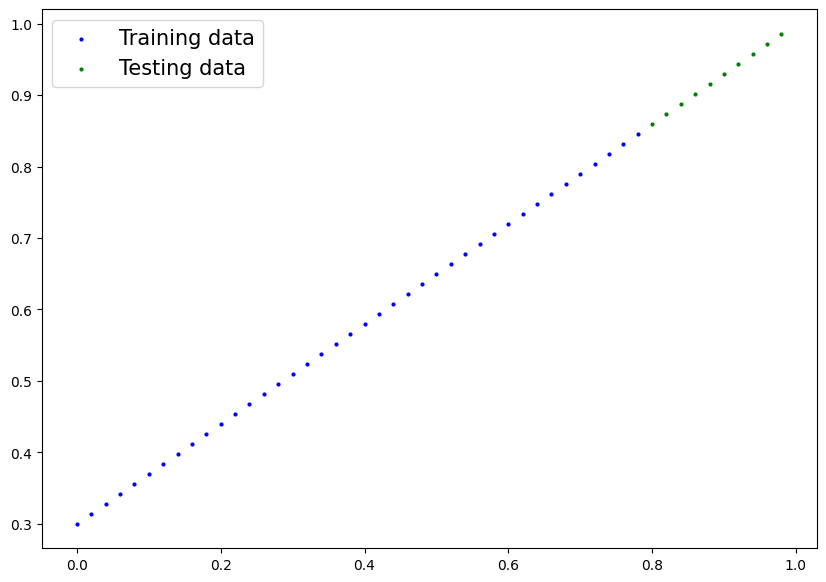

In [28]:
plot_predictions()

## Building a model

**Torch.nn.module**:
- Base class for all neural network modules
- new models created must also subclass this class

In [29]:
# Creating a pure pytorch model class

class LinearRefressionModel(nn.Module):

   def __init__(self):

     super().__init__()

     self.weights = nn.Parameter(torch.randn( 1,
                                              requires_grad= True,
                                              dtype = torch.float32
                                              ))

     self.bias = nn.Parameter(torch.randn(1,
                                          requires_grad = True,
                                          dtype = torch.float32
                                          ))

  # Defining Forward propagation in the model
   def forward(self , x : torch.Tensor) -> torch.Tensor:

     return self.weights * x + self.bias

### PyTorch model building essentials
PyTorch has 4 essential modules that can be used to create almost any kind of neural network. They are:
1. **torch.nn**
2. **torch.optim**
3. **torch.utils.data.Dataset**
4. **torch.utils.data.DataLoader**

**Note:** Here we have initialized the weights manually, but for complex models there are different methods to initialize it

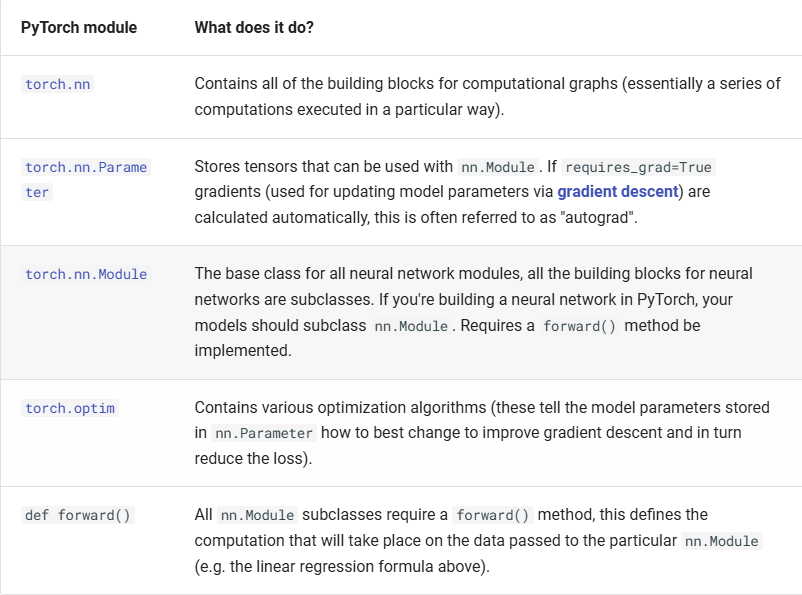

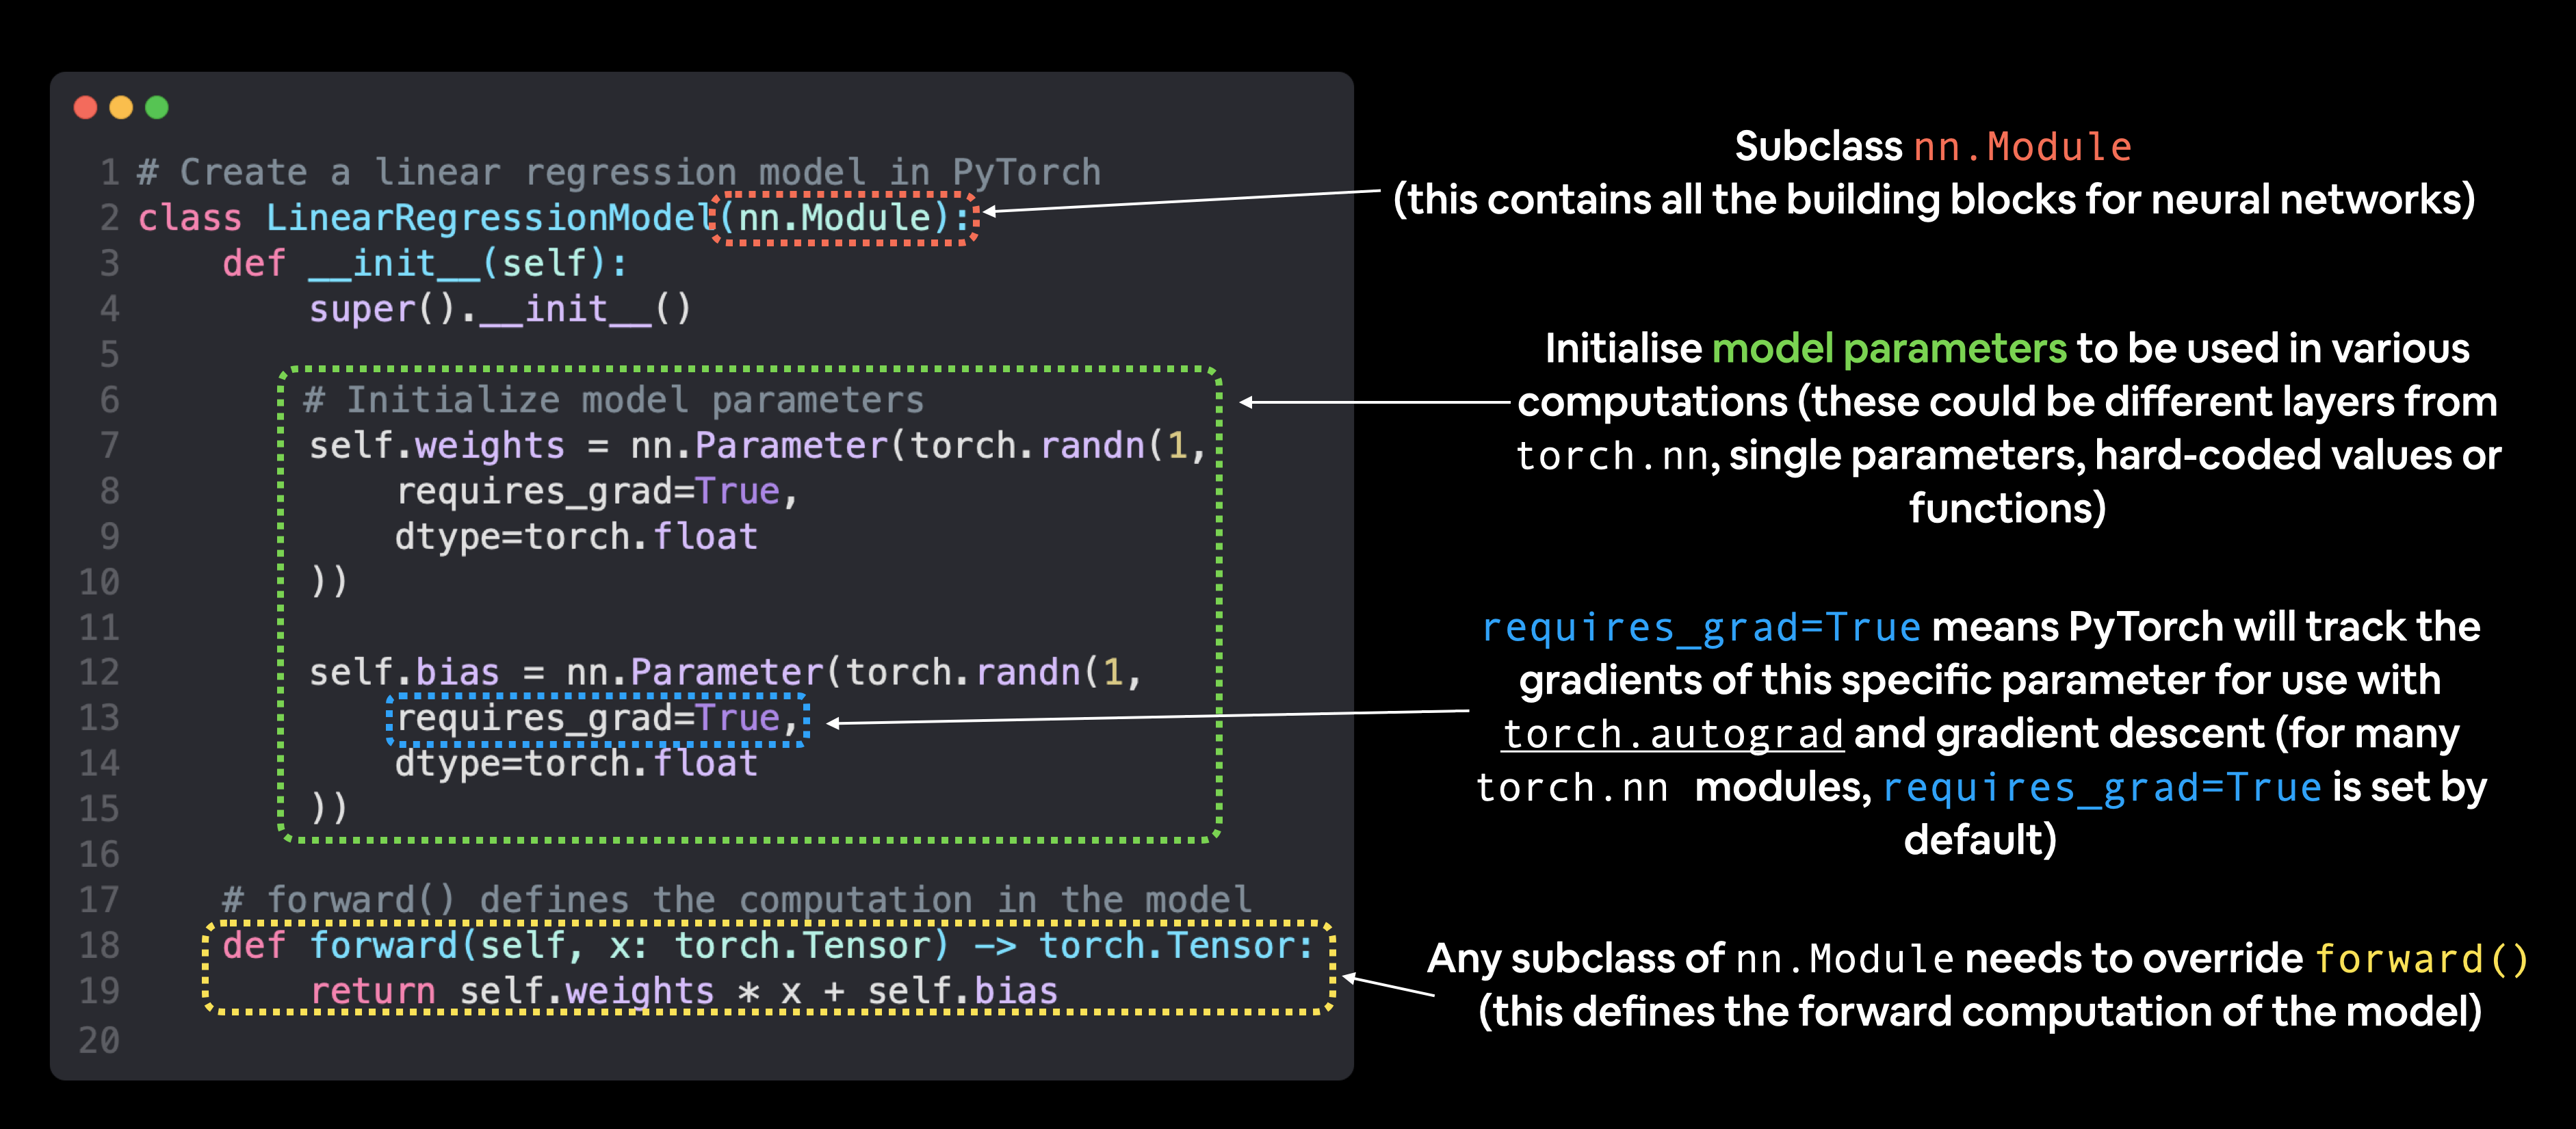

## Checking the contents of PyTorch Model
we can check the parameters of a model instance of the model class using *.parameters()*

In [30]:
torch.manual_seed(42)

model_0 = LinearRefressionModel()

#Checking parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [31]:
#List the parameters with their names

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Predictions using `torch.inference_mode()`
- When we pass X_test to our model, it will go through the model's forward() method and returns the computation we have defined.
- InferenceMode is a context manager analogous to no_grad to be used when you are certain your operations will have no interactions with autograd (e.g., model training).
- Code run under this mode gets better performance by disabling view tracking and version counter bumps
- `torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

In [32]:
#use of with for proper resource management
class anything:

  def __enter__(self):
    print("resource acquired")
    return self

  def __exit__(self , exc_type , exc_value , traceback):
    print('resource released')

  def hello(self):
    print('Hello')

with anything() as resource:
  print("Using the resources")
  resource.hello()


resource acquired
Using the resources
Hello
resource released


In [33]:
# make predictions with model without training
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [34]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

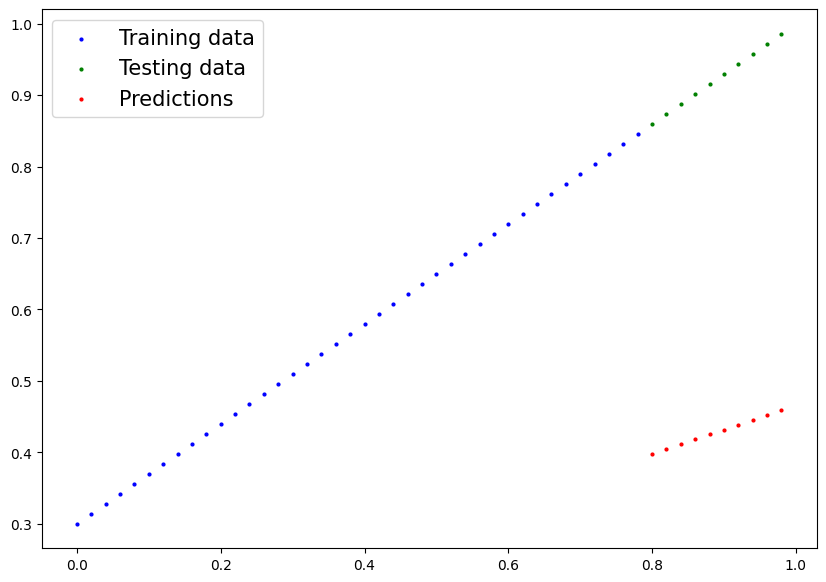

In [36]:
plot_predictions(predictions = y_preds)

In [38]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## 3. Train the model
- We need to optimize the values of the parameters `weights` and `bias` to get them as close as posible to their true value
- In most ML problems we will not know the ideal values of the parameters for the model.

### Creating a loss function and optimizer in PyTorch
**1. Loss Function:** Measures how far our predictions are from its true value. Lower the better

**2. Optimizer:** Tells the model how to update the parameters to lower the loss in the most fast and best way possible

**NOTE:** The use of loss function and optimizer depends on the kind of problem present

Mean Absolute Error : Regression problem

Binary cross entropy : binary classification

categorical cross entropy : multilevel classification

**For Our Problem**
We will use MAE given by : `torch.nn.L1Loss` and SGD as optimizer : `torch.optim.SGD(params,lr)` where:

- `params` is the target model parameters you'd like to optimize (e.g. the weights and bias values we randomly set before).
- `lr` is the learning rate you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a hyperparameter (because it's set by a machine learning engineer). Common starting values for the learning rate are 0.01, 0.001, 0.0001, however, these can also be adjusted over time

In [39]:
# Create the loss function
loss_fn = nn.L1Loss()

# Create the optimizer

opimizer = torch.optim.SGD(params = model_0.parameters() , lr = 0.01)

## Creating an optimization loop in PyTorch
- optimization loop refers to tranining loop
- traning loop involves the model going through the training data and learning the relationships between the `features` and `labels`.
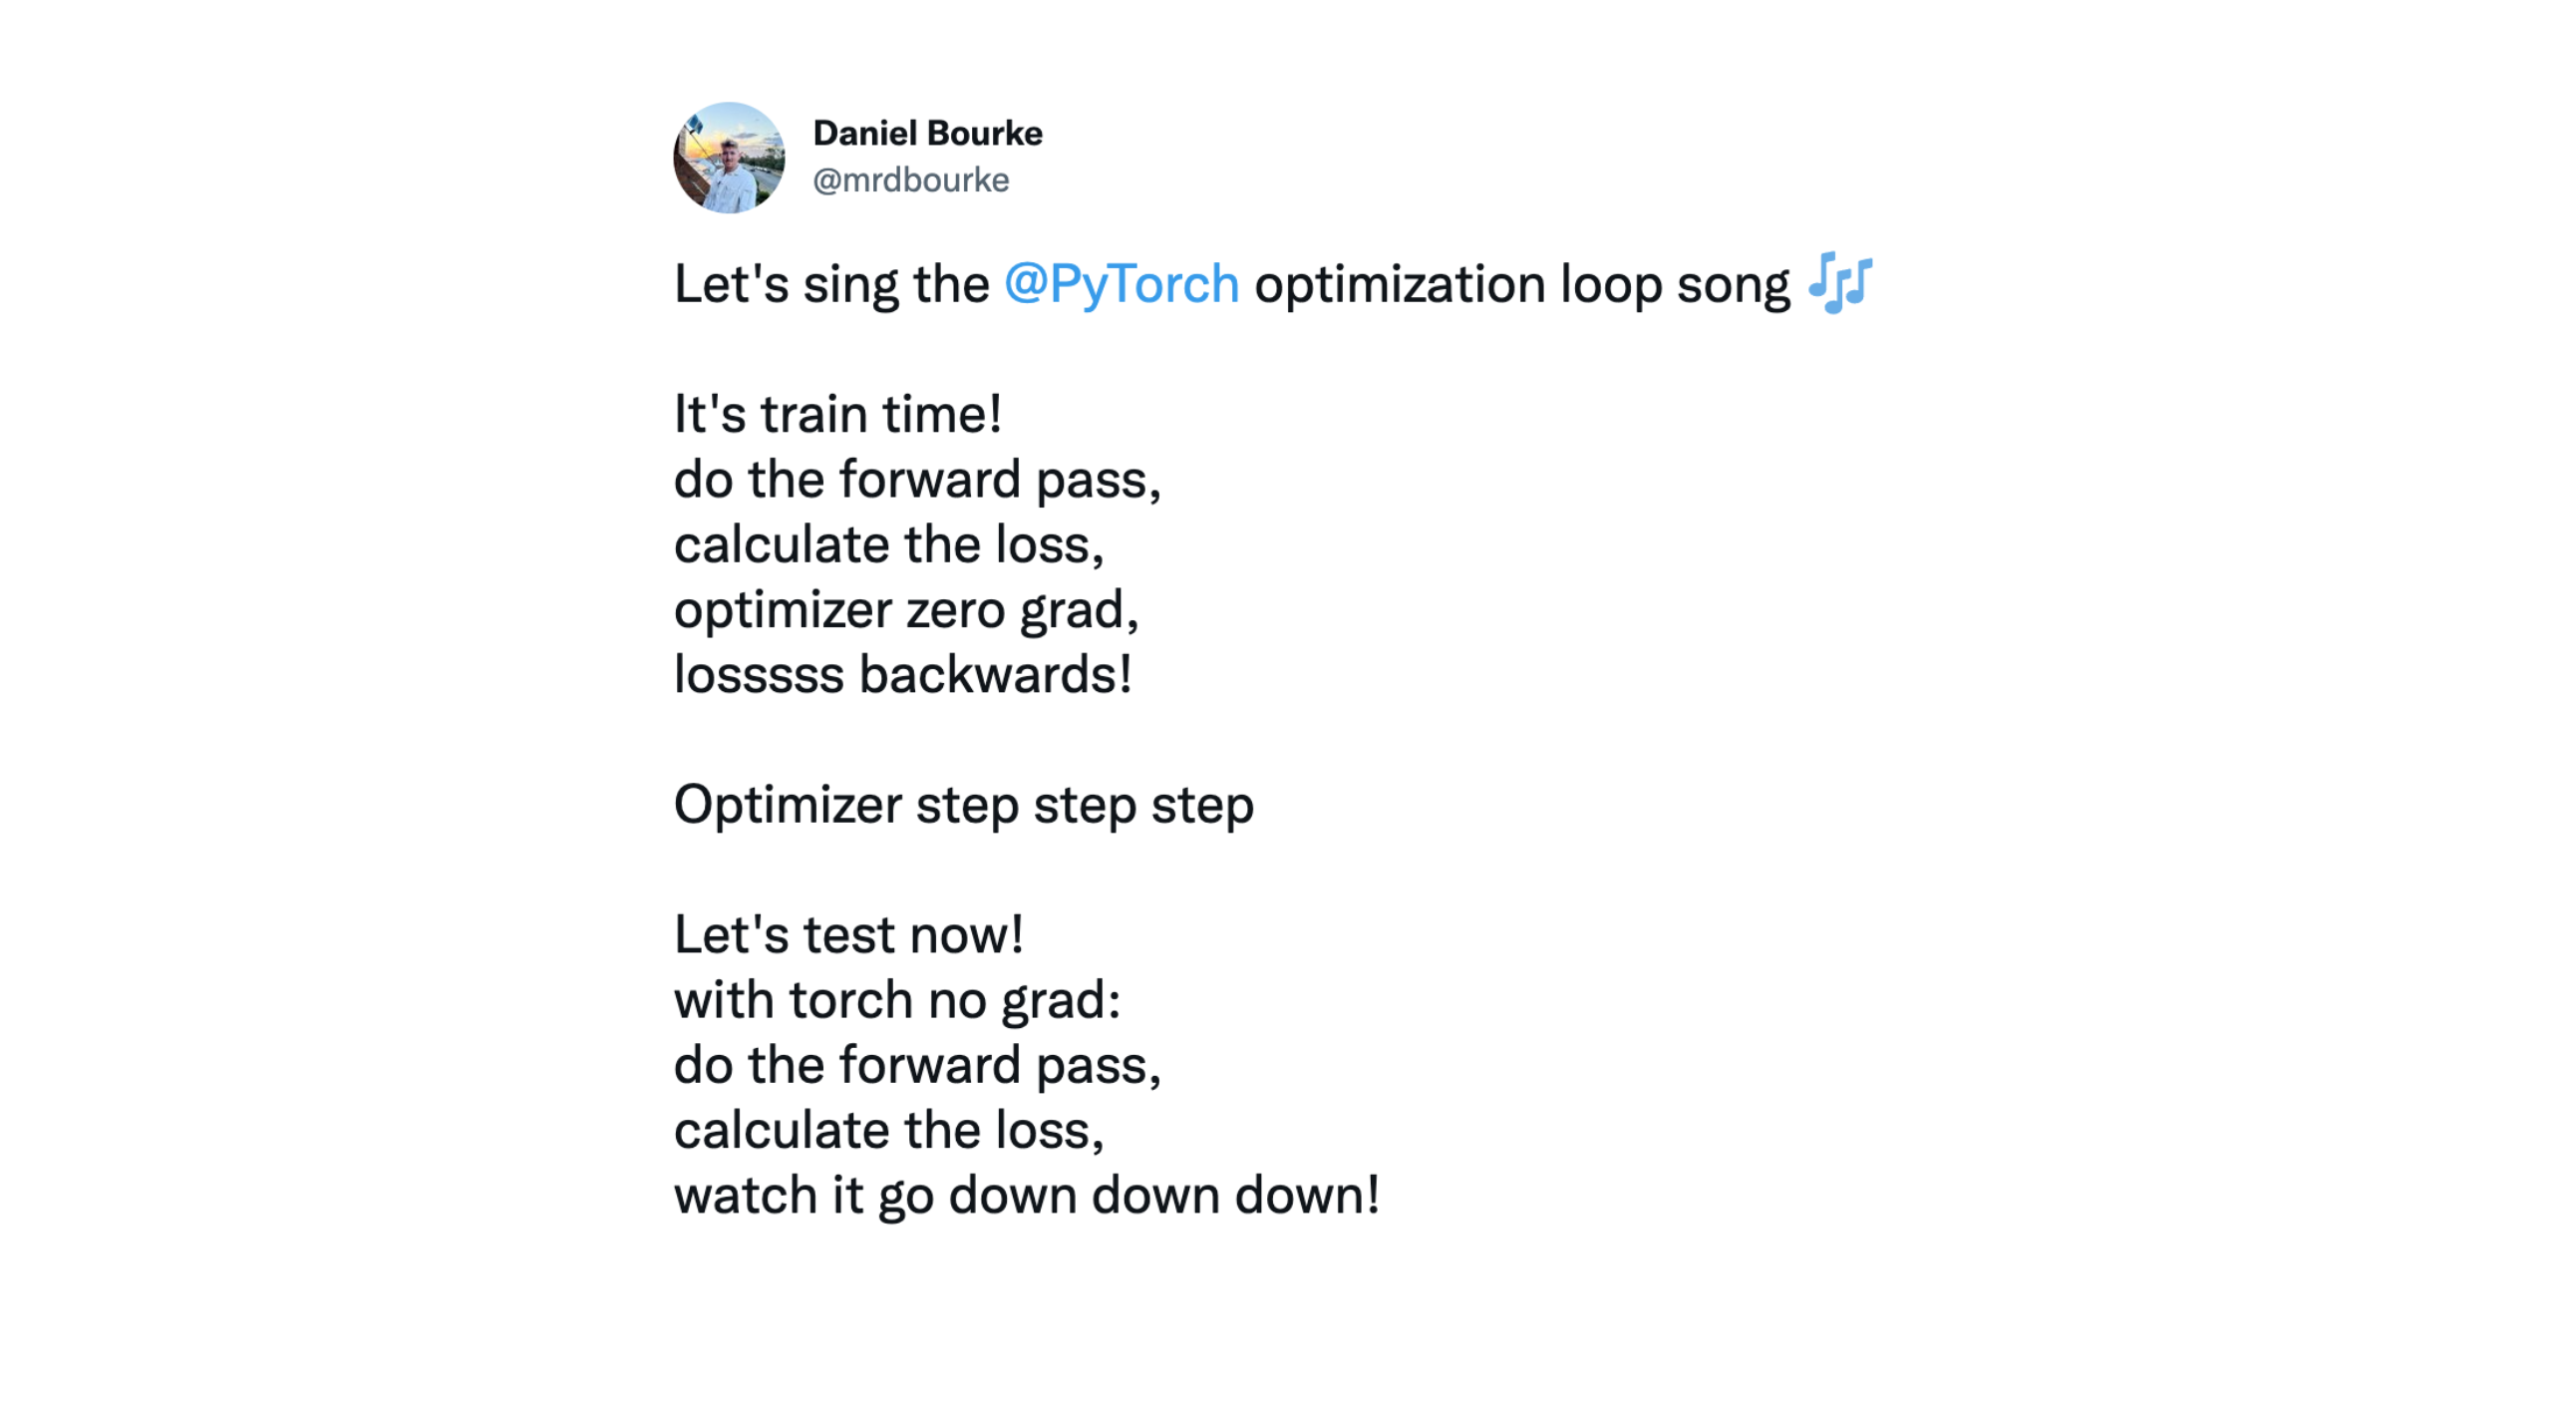


1. `Forward Pass`: The model goes through all of the training data once, performing its forward() function calculations. : `model(X_train)

2. `Calculate Loss`: he model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are : `loss = loss_fn(y_pred , y _train)`

3. `Zero gradients` : loops to reset (zero out) the gradients of all the model's parameters before performing a new backpropagation step. This is a crucial part of training a neural network, as it ensures that gradients from previous iterations do not accumulate and interfere with the current update. : `optimizer.zero_grad()`

4. `Perform Backpropagation` : loss.backwards()

5. `update the parameters` : optimizer.step()